In [1]:
import pandas as pd
import polars as pl
from pandas.api.types import CategoricalDtype
import seaborn as sns
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import importlib

plt.rcParams["figure.dpi"] = 120


summary_statistics_folder = 'intermediate_data_fullgenome'
if os.getcwd()!='phasing_T2T_project':
    os.chdir('..') # Change to the parent directory

In [2]:
binned_maf_data = pd.read_parquet(f"{summary_statistics_folder}/binned_maf_data.parquet")

all_chroms = pd.read_parquet(f'{summary_statistics_folder}/chroms.parquet')
all_samples = pd.read_parquet(f'{summary_statistics_folder}/samples.parquet')
all_ancestries = pd.read_parquet(f'{summary_statistics_folder}/ancestries.parquet')
all_methods = pd.read_parquet(f'{summary_statistics_folder}/methods.parquet')

per_variant_category_imputation_performance = pd.read_parquet(f'{summary_statistics_folder}/per_variant_category_imputation_performance.parquet')
per_sample_imputation_performance = pd.read_parquet(f'{summary_statistics_folder}/per_sample_imputation_performance.parquet')

rolling_window_ideogram_250k = pd.read_parquet(f'{summary_statistics_folder}/rolling_stats_250k_window.parquet')

In [3]:
#Post hoc fixes - one off events that are tricky to deal with when compiling stats

# there is one variant (I have not investigated, but likely a denovo SNP) that is a singleton variant in the HPRC dataset. 
# That variant passed all filters, but makes for a very odd figure (correctly phased: 0% error rate, incorrect: 100% error rate)
# We will trim it here
binned_maf_data.loc[(binned_maf_data.ground_truth_data_source == 'HPRC_samples')&
                    (binned_maf_data.method_of_phasing == 'phased_with_parents_and_pedigree')&
                    (binned_maf_data.rounded_MAF == 'singleton'), ['n_switch_errors','n_checked','switch_error_rate']] = np.nan

# Isolate syntenic vs nonsyntenic regions
regional_binned_maf_data = binned_maf_data.copy()
binned_maf_data = (binned_maf_data.loc[binned_maf_data.region.isin(['syntenic','nonsyntenic','All'])]
                                  .replace('syntenic','Syntenic')
                                  .replace('nonsyntenic','Nonsyntenic')
                                  .rename(columns={'region':'Syntenic'}))

# Nonsyntenic GRCh38 regions are simply GRCh38 errors, and we are not interested in the performance in these regions
binned_maf_data = binned_maf_data.loc[~((binned_maf_data.genome=='GRCh38')&(binned_maf_data.Syntenic=='Nonsyntenic'))]

# NA20355 is a duo member, and as such was not part of duohmm trio correction for the GRCh38 2022 effort.
all_chroms.loc[(all_chroms.genome=='GRCh38')&(all_chroms['sample_id']=='NA20355'), 'trio_phased'] = False
all_samples.loc[(all_samples.genome=='GRCh38')&(all_samples['sample_id']=='NA20355'), 'trio_phased'] = False
all_chroms = all_chroms.loc[~((all_chroms.genome=='GRCh38')&(all_chroms['sample_id']=='NA20355')&(all_chroms.ground_truth_data_source.isin(['HPRC_HGSVC_probands','HGSVC_probands'])))]
all_samples = all_samples.loc[~((all_samples.genome=='GRCh38')&(all_samples['sample_id']=='NA20355')&
                                (all_samples.ground_truth_data_source.isin(['HPRC_HGSVC_probands','HGSVC_probands'])))]

# very high variance stats when n_checked is less than 10. Replace switch error rate at these sites with np.nan
binned_maf_data.loc[(binned_maf_data.n_checked>10), 'switch_error_rate'] = binned_maf_data.loc[(binned_maf_data.n_checked>10), 'switch_error_rate'].replace(0, np.nan)

# bins with a switch error rate of 0 make for insane figures when plotted on a log scale. Replace with np.nan, and maybe note
binned_maf_data['switch_error_rate'] = binned_maf_data['switch_error_rate'].replace(0, np.nan)

# A reviewer suggests combining chrX, PAR1, and PAR2 statistics. I will do that, and set male chrX switch error rates to np.nan.
## Calculate percent discordance in imputation performance
if 'perc_discordance' not in per_variant_category_imputation_performance.columns:
    per_variant_category_imputation_performance = per_variant_category_imputation_performance.loc[per_variant_category_imputation_performance.num_AA > 0]
    if max(per_variant_category_imputation_performance.mean_AF) < 1:
        per_variant_category_imputation_performance.mean_AF *= 100
    per_variant_category_imputation_performance['num_alt_mismatches'] = per_variant_category_imputation_performance.num_Aa_mismatches + per_variant_category_imputation_performance.num_aa_mismatches
    per_variant_category_imputation_performance['num_alt_variants'] = per_variant_category_imputation_performance.num_Aa + per_variant_category_imputation_performance.num_aa
    per_variant_category_imputation_performance['perc_discordance'] = per_variant_category_imputation_performance['num_alt_mismatches']/per_variant_category_imputation_performance['num_alt_variants']*100
    per_variant_category_imputation_performance['perc_concordance'] = 100-per_variant_category_imputation_performance['perc_discordance']

# imputed df needs to have CHM13v2.0 as genome name instead of T2T
per_variant_category_imputation_performance = per_variant_category_imputation_performance.replace('T2T','CHM13v2.0')
per_sample_imputation_performance = per_sample_imputation_performance.replace('T2T','CHM13v2.0')

# A supplemental calculates SER by % of chromosome that is new. we calc that here.
if 'percent_new' not in all_chroms.columns:
    syntenic_bed = pd.read_csv('resources/hg38.GCA_009914755.4.synNet.summary.bed.gz', sep='\t', header=None)
    syntenic_bed.columns = ['chrom','start','end','status']
    starts = syntenic_bed.groupby('chrom').first().reset_index()
    syntenic_bed['length'] = syntenic_bed.end-syntenic_bed.start
    syntenic_bed['dif'] = syntenic_bed.end.diff()
    syntenic_bed['nonsyn_len'] = syntenic_bed.dif - syntenic_bed.length
    syntenic_bed.loc[syntenic_bed.nonsyn_len < 0, 'nonsyn_len'] = syntenic_bed.loc[syntenic_bed.nonsyn_len < 0, 'start']
    syntenic_bed.loc[syntenic_bed.nonsyn_len.isna(), 'nonsyn_len'] = syntenic_bed.loc[syntenic_bed.nonsyn_len.isna(), 'start']
    rough_length = syntenic_bed.groupby('chrom').end.max().reset_index()
    chr_nonsyn_lengths = syntenic_bed.groupby('chrom').sum(numeric_only=True).reset_index()[['chrom','nonsyn_len']]
    chr_nonsyn_lengths = chr_nonsyn_lengths.merge(rough_length, on='chrom')
    chr_nonsyn_lengths['percent_new'] = chr_nonsyn_lengths.nonsyn_len/chr_nonsyn_lengths.end * 100
    all_chroms = all_chroms.merge(chr_nonsyn_lengths[['chrom', 'percent_new']], on=['chrom'],how='left')

all_chroms_chrX = all_chroms.loc[all_chroms.chrom.isin(('chrX','PAR1','PAR2'))].assign(chrom='chrX')
all_chroms_chrX = all_chroms_chrX.groupby(['chrom','genome','sample_id','method_of_phasing','ground_truth_data_source','population', 'superpopulation', 'sex', 'trio_phased'],observed=True).sum(numeric_only=True).reset_index()
all_chroms_chrX.loc[all_chroms_chrX.sex=='Male', ['n_switch_errors','n_total_switch_errors','n_flips','n_consecutive_flips','n_true_switch_errors','num_correct_phased_hets',
                                                  'n_total_hets','flip_and_switches_SER', 'flip_error_rate', 'true_switch_error_rate','accurately_phased_rate']] = np.nan

all_chroms_chrX['switch_error_rate'] = all_chroms_chrX.n_switch_errors/all_chroms_chrX.n_checked * 100
all_chroms_chrX['gt_error_rate'] = all_chroms_chrX.n_gt_errors/all_chroms_chrX.n_gt_checked * 100
all_chroms_chrX['flip_and_switches_SER'] = all_chroms_chrX.n_total_switch_errors/all_chroms_chrX.n_total_hets * 100
all_chroms_chrX['flip_error_rate'] = all_chroms_chrX.n_flips/all_chroms_chrX.n_total_hets * 100
all_chroms_chrX['true_switch_error_rate'] = all_chroms_chrX.n_true_switch_errors/all_chroms_chrX.n_total_hets * 100

all_chroms_chrX = pd.concat((all_chroms_chrX, all_chroms.loc[~all_chroms.chrom.isin(('chrX','PAR1','PAR2'))])).drop(columns=['L50','N50','percent_new'])


binned_maf_data = binned_maf_data.sort_values('type', key=lambda col: col.apply(lambda x: {'Indel':0, 'SNP':1, 'SNPs + Indels':2}.get(x,x)))
binned_maf_data = binned_maf_data.sort_values('genome', key=lambda col: col.apply(lambda x: {'GRCh38':0, 'CHM13v2.0':1}.get(x,x)))

if binned_maf_data['switch_error_rate'].max() < 1:
    binned_maf_data['switch_error_rate'] *= 100
if binned_maf_data['gt_error_rate'].max() < 1:
    binned_maf_data['gt_error_rate'] *= 100
if binned_maf_data['MAF'].max() < 1:
    binned_maf_data['MAF'] *= 100

# a handful of variants are miscategorized as singletons. There are no true GRCh38 singletons. We can fix this.
binned_maf_data = binned_maf_data.loc[~((binned_maf_data.rounded_MAF=='singleton')&(binned_maf_data.genome=='GRCh38')&(binned_maf_data.method_of_phasing=='phased_with_parents_and_pedigree')&(binned_maf_data.ground_truth_data_source!='trios'))]



In [4]:
oneKGP_meta = pd.read_csv('resources/1000_genomes_meta.tsv', sep='\t')
overlaps = oneKGP_meta.loc[oneKGP_meta['Sample name'].isin(all_samples.sample_id.unique()) & oneKGP_meta['Data collections'].str.contains('Simons Genome'), 'Sample name']
overlaps.to_csv('resources/sample_subsets/SGDP_samples_in_1KGP.txt', index=False, header=False)

In [5]:
pedigree = pd.read_csv('resources/pedigrees/1kGP.3202_samples.pedigree_info.txt', sep=' ')

### Variant Filtering Stats 
Stats in paragraph after "Full length, telomere to telomere maps of human genetic recombination rates are largely consistent with deCODE recombination rates"

In [6]:
sum_stats_var_filters = pd.read_parquet(f"{summary_statistics_folder}/filter_summary_stats.parquet")

grch38_filter_columns=['MERR_filter', 'HWE_pop_filter','AC_filter',
       'f_missing_filter', 'var_len_filter', 'alt_star_filter', 'pass_filter']
chm13_filter_columns=[#'neg_train_site_filter',
       'VQSLOD_filter', 'MERR_filter', 'HWE_pop_filter', 'MAC_filter',
       'f_missing_filter', 'var_len_filter', 'alt_star_filter', 'pass_filter']

sum_stats_var_filters['gatk_filters'] = sum_stats_var_filters.VQSLOD_filter #| sum_stats_var_filters.neg_train_site_filter
sum_stats_var_filters['GRCh38_criteria_pass_if_singletons_passed'] = ~sum_stats_var_filters[[x for x in grch38_filter_columns if x != 'AC_filter'] + ['MAC_filter']].any(axis=1)

num_singletons_gained = sum_stats_var_filters.loc[ (sum_stats_var_filters.genome=='CHM13v2.0') &
                                                   ~sum_stats_var_filters.CHM13_criteria_fail &
                                                    sum_stats_var_filters.singleton &
                                                    sum_stats_var_filters.GRCh38_criteria_fail &
                                                    sum_stats_var_filters.GRCh38_criteria_pass_if_singletons_passed].len.sum()
num_variants_lost_to_gatk = sum_stats_var_filters.loc[ (sum_stats_var_filters.genome=='CHM13v2.0') &
                                                        sum_stats_var_filters.CHM13_criteria_fail &
                                                       ~sum_stats_var_filters.GRCh38_criteria_fail &
                                                        sum_stats_var_filters.gatk_filters &
                                                        sum_stats_var_filters.GRCh38_criteria_pass_if_singletons_passed].len.sum()

print(f"CHM13 variants lost to gatk-based filters:\n{num_variants_lost_to_gatk}")
print(f"CHM13 variants gained due to ability to include singletons:\n{num_singletons_gained}")

CHM13 variants lost to gatk-based filters:
14491949
CHM13 variants gained due to ability to include singletons:
40226623


The resulting panel contains 6404 haplotypes and XXX unique variants, including XXX phased variants in novel regions of the CHM13v2.0 genome.

In [7]:
number_unique_CHM13_variants = sum_stats_var_filters.loc[~sum_stats_var_filters.CHM13_filtered & (sum_stats_var_filters.genome=='CHM13v2.0')].len.sum()
number_unique_syntenic_CHM13_variants = sum_stats_var_filters.loc[~sum_stats_var_filters.Syntenic & ~sum_stats_var_filters.CHM13_filtered & (sum_stats_var_filters.genome=='CHM13v2.0')].len.sum()
print(f"Unique variants: {number_unique_CHM13_variants}")
print(f"Unique novel variants: {number_unique_syntenic_CHM13_variants}")

Unique variants: 75135193
Unique novel variants: 244718


We observed that samples that underwent Mendelian pre-phasing (Figure 2a, c) had lower SERs than samples that underwent statistical phasing (Figure 2b, d; XXX% vs XXX%).

In [8]:
trio_vs_nontrio = all_samples.loc[all_samples.ground_truth_data_source.isin(['HPRC_samples', 'HGSVC_samples_nontrios_only']) & 
                                    (all_samples.method_of_phasing == 'phased_with_parents_and_pedigree')&
                                    (all_samples.genome=='GRCh38')
                                    ].groupby('ground_truth_data_source', observed=True).sum(numeric_only=True)

trio_vs_nontrio['switch_error_rate'] = trio_vs_nontrio.n_switch_errors/trio_vs_nontrio.n_checked * 100
trio_vs_nontrio.switch_error_rate

ground_truth_data_source
HPRC_samples                   0.407948
HGSVC_samples_nontrios_only    1.280732
Name: switch_error_rate, dtype: float64

### Number of reference samples that are probands/parents/unrelateds

In [9]:
pedigree = pedigree.replace('0', np.nan)
num_that_are_children_and_parents = pedigree.loc[pedigree.sampleID.isin(pedigree.fatherID) | pedigree.sampleID.isin(pedigree.motherID) & ~(pedigree.fatherID.isna() | pedigree.motherID.isna())]

In [10]:
children_that_are_parents = pedigree.loc[(pedigree.sampleID.isin(pedigree.fatherID) | pedigree.sampleID.isin(pedigree.motherID)) & (~pedigree.fatherID.isna() | ~pedigree.motherID.isna())].sampleID
pedigree['trio_status'] = np.nan
complex_pedigrees = pedigree.loc[pedigree.sampleID.isin(children_that_are_parents) | pedigree.motherID.isin(children_that_are_parents) | pedigree.fatherID.isin(children_that_are_parents)]
simple_trios = pedigree.loc[~pedigree.index.isin(complex_pedigrees.index) & (~pedigree.fatherID.isna() & ~pedigree.motherID.isna())]
simple_duos = pedigree.loc[~pedigree.index.isin(complex_pedigrees.index) & (~pedigree.fatherID.isna() ^ ~pedigree.motherID.isna())]
relatives = pd.concat((simple_duos, simple_trios, complex_pedigrees))
relatives = relatives.fatherID.dropna().tolist() + relatives.motherID.dropna().tolist() + relatives.sampleID.tolist()
relatives = pedigree.loc[pedigree.sampleID.isin(relatives)]
no_relatives = pedigree.loc[~pedigree.sampleID.isin(relatives.sampleID)]


In [11]:
proband_or_not_trio = pedigree.loc[~(pedigree.sampleID.isin(pedigree.fatherID) | pedigree.sampleID.isin(pedigree.motherID))]

In [12]:
def get_parents(df):
    return df.fatherID.dropna().to_list() + df.motherID.dropna().to_list()

complex_people = [x for x in get_parents(complex_pedigrees) if x in complex_pedigrees.sampleID.tolist()]

complex_trio_parents = [x for x in get_parents(complex_pedigrees.loc[~(complex_pedigrees.fatherID.isna() | complex_pedigrees.motherID.isna())]) if x not in complex_pedigrees.sampleID.tolist()]
complex_duo_parents = [x for x in get_parents(complex_pedigrees.loc[(complex_pedigrees.fatherID.isna() ^ complex_pedigrees.motherID.isna())]) if x not in complex_pedigrees.sampleID.tolist()]
complex_trio_children = [x for x in complex_pedigrees.loc[~(complex_pedigrees.fatherID.isna() | complex_pedigrees.motherID.isna())].sampleID.to_list() if x not in get_parents(complex_pedigrees)]
complex_duo_children = [x for x in complex_pedigrees.loc[(complex_pedigrees.fatherID.isna() ^ complex_pedigrees.motherID.isna())].sampleID.to_list() if x not in get_parents(complex_pedigrees)]
simple_pedigrees = pedigree.loc[~pedigree.index.isin(complex_pedigrees.index)]
simple_trios = simple_pedigrees.loc[~(simple_pedigrees.fatherID.isna() | simple_pedigrees.motherID.isna())]
trio_parents = get_parents(simple_trios) + complex_trio_parents
trio_children = simple_trios.sampleID.to_list() + complex_trio_children
simple_duos = simple_pedigrees.loc[(simple_pedigrees.fatherID.isna() ^ simple_pedigrees.motherID.isna())]
duo_parents = get_parents(simple_duos) + complex_duo_parents
duo_children = simple_duos.sampleID.to_list() + complex_duo_children

trio_dads = simple_trios.fatherID.dropna().to_list() + [x for x in complex_trio_parents if x in complex_pedigrees.fatherID.tolist()]
trio_moms = simple_trios.motherID.dropna().to_list() + [x for x in complex_trio_parents if x in complex_pedigrees.motherID.tolist()]

len(set(trio_moms)), len(set(trio_dads)), len(set(trio_parents)), len(set(duo_parents)), len(set(trio_children)), len(set(duo_children)), len(complex_people)

## Describes the parent who is in two duo/trios
pedigree.loc[(pedigree.sampleID=='NA19238')|(pedigree.fatherID=='NA19238')|(pedigree.motherID=='NA19238')]

,sampleID,fatherID,motherID,sex,trio_status
2504,NA18913,NaN,NA19238,1,NaN
2731,NA19238,NaN,NaN,2,NaN
2733,NA19240,NA19239,NA19238,2,NaN


### Export per-sample statistics for supplemental table 1

In [13]:
samples_for_export = all_samples.loc[(all_samples.method_of_phasing=='phased_with_parents_and_pedigree')&(all_samples.ground_truth_data_source.isin(('HPRC_samples','HGSVC_samples')))]
sample_export_columns = ['sample_id', 'panel_genome', 'ground_truth_data_source', 'family_status','population', 'superpopulation', 'sex', 'n_switch_errors', 'n_checked', 'switch_error_rate',
       'n_total_switch_errors', 'n_flips', 'n_consecutive_flips',
       'n_true_switch_errors', 'num_correct_phased_hets', 'n_total_hets',
       'flip_and_switches_SER', 'flip_error_rate', 'true_switch_error_rate',
       'accurately_phased_rate', 'n_gt_errors', 'n_gt_checked',
       'gt_error_rate', 'N50']

source_accuracy_columns = ['panel_genome', 'ground_truth_data_source', 'family_status', 'n_switch_errors', 'n_checked', 'switch_error_rate',
       'n_total_switch_errors', 'n_flips', 'flip_error_rate',
       'n_true_switch_errors', 'n_total_hets','true_switch_error_rate',
       'n_gt_errors', 'n_gt_checked',
       'gt_error_rate', 'N50']

samples_for_export = samples_for_export.sort_values(['genome','ground_truth_data_source', 'sample_id']).rename(columns={'genome':'panel_genome'})
samples_for_export['family_status'] = 'non_trio'
samples_for_export.loc[samples_for_export.trio_phased,'family_status'] = 'trio_proband'
samples_for_export.loc[samples_for_export.sample_id.isin(pedigree.fatherID.to_list()+pedigree.motherID.to_list()),'family_status'] = 'trio_parent'
source_accuracy = samples_for_export[sample_export_columns].groupby(['panel_genome','ground_truth_data_source','family_status'], observed=True).sum(numeric_only=True).reset_index()
source_accuracy['switch_error_rate'] = source_accuracy.n_switch_errors/source_accuracy['n_checked'] * 100
source_accuracy['gt_error_rate'] = source_accuracy['n_gt_errors']/source_accuracy['n_gt_checked'] * 100
source_accuracy['true_switch_error_rate'] = source_accuracy.n_true_switch_errors/source_accuracy.n_total_hets * 100
source_accuracy['flip_error_rate'] = source_accuracy.n_flips/source_accuracy.n_total_hets * 100
os.makedirs('figures/supplemental/tables', exist_ok=True)
source_accuracy[source_accuracy_columns].to_csv('figures/supplemental/tables/supplemental_ground_truth_source_accuracy_data_unformatted.tsv', sep='\t', index=False)
samples_for_export[sample_export_columns].to_csv('figures/supplemental/tables/supplemental_per_sample_data_unformatted.tsv', sep='\t', index=False)
source_accuracy.T

,0,1,2,3,4,5,6,7
panel_genome,GRCh38,GRCh38,GRCh38,GRCh38,CHM13v2.0,CHM13v2.0,CHM13v2.0,CHM13v2.0
ground_truth_data_source,HPRC_samples,HGSVC_samples,HGSVC_samples,HGSVC_samples,HPRC_samples,HGSVC_samples,HGSVC_samples,HGSVC_samples
family_status,trio_proband,non_trio,trio_parent,trio_proband,trio_proband,non_trio,trio_parent,trio_proband
n_switch_errors,474899,721620,282761,396029,361950,511618,174592,333248
n_checked,116411762,55578917,40080199,85364549,101999287,46079440,35237358,77833807
switch_error_rate,0.407948,1.29837,0.705488,0.463927,0.354855,1.110296,0.495474,0.428153
n_total_switch_errors,474899,721620,282761,396029,361950,511618,174592,333248
n_flips,216913,277200,121977,184339,169732,219366,83125,157725
n_consecutive_flips,7184,27455,6508,5243,3390,12846,1439,3281
n_true_switch_errors,33889,139765,32299,22108,19096,60040,6903,14517


In [14]:
def group_phasing_statistics(df, columns_to_groupby):
    df_cols = df.columns
    assert all([c in df_cols for c in columns_to_groupby])

    df = df.groupby(columns_to_groupby, observed=True).sum(numeric_only=True).reset_index()

    if 'n_gt_errors' in df_cols:
        df['gt_error_rate'] = df.n_gt_errors/df.n_gt_checked * 100
    if 'n_true_switch_errors' in df_cols:
        # See definitions below.
        df['flip_error_rate'] = df.n_flips/df.n_checked*100
        df['true_switch_error_rate'] = df.n_true_switch_errors/df.n_checked*100
    if 'n_switch_errors' in df_cols:
        df['switch_error_rate'] = df.n_switch_errors/df.n_checked*100

    return df

chrX = all_chroms.loc[(all_chroms.sex=='Female')&(all_chroms.chrom=='chrX') & (all_chroms.method_of_phasing=='phased_with_parents_and_pedigree') & all_chroms.ground_truth_data_source.isin(['HPRC_samples','HGSVC_samples_nontrios_only',])]

group_phasing_statistics(chrX, ['genome','ground_truth_data_source'])

,genome,ground_truth_data_source,n_switch_errors,n_checked,switch_error_rate,n_total_switch_errors,n_flips,n_consecutive_flips,n_true_switch_errors,num_correct_phased_hets,...,flip_and_switches_SER,flip_error_rate,true_switch_error_rate,accurately_phased_rate,n_gt_errors,n_gt_checked,gt_error_rate,trio_phased,N50,percent_new
0,GRCh38,HPRC_samples,22059,2414208,0.913716,22059,7768,330,6193,2392149,...,21.045021,0.321762,0.256523,2271.275904,268160.0,18126553,1.479377,23,11296600.0,76.052737
1,GRCh38,HGSVC_samples_nontrios_only,9007,597692,1.506963,9007,2851,264,3041,588685,...,10.400772,0.477002,0.508790,686.032609,82156.0,2585422,3.177663,0,2833560.0,23.146485
2,CHM13v2.0,HPRC_samples,9068,2173783,0.417153,9068,4334,58,342,2164715,...,9.536867,0.199376,0.015733,2285.865213,238853.0,16257872,1.469153,23,34129171.0,76.052737
3,CHM13v2.0,HGSVC_samples_nontrios_only,8618,548108,1.572318,8618,3585,335,1113,539490,...,11.224752,0.654068,0.203062,683.683798,74578.0,2387889,3.123177,0,3651775.0,23.146485


In [15]:
### Data generated in make_figures.ipynb

error_rate_corr = pd.read_csv('figures/correlation_error_rates_and_gt_error_rate.csv')
error_rate_corr

FileNotFoundError: [Errno 2] No such file or directory: 'figures/correlation_error_rates_and_gt_error_rate.csv'

In [ ]:
HPRC_samples_phased_with_panel = binned_maf_data.loc[(binned_maf_data.ground_truth_data_source=='HPRC_samples')&(binned_maf_data.method_of_phasing == '1kgp_variation_phased_with_reference_panel')]
HPRC_samples_phased_with_panel = group_phasing_statistics(HPRC_samples_phased_with_panel, ['type','genome','Syntenic']).drop(columns=['MAC','AN','MAF'])
error_rate_corr.to_csv('figures/panel_phased_HPRC_samples_summary_data.csv', index=False)

## Get number of probands/parents in 1KGP

In [ ]:
parents = len(trio_parents) + len(duo_parents)
probands = len(trio_children) + len(duo_children)
statistical = 3202-parents-probands
parents, probands, statistical

(1206, 604, 1392)

In [ ]:
number_of_datasets_per_sample = all_samples.loc[(all_samples.genome=='GRCh38') &
                                (all_samples['method_of_phasing']=='phased_with_parents_and_pedigree') &
                                (all_samples.ground_truth_data_source.isin(('HPRC_samples','HGSVC_samples')))
                                ].groupby(['sample_id'], observed=True).size().sort_values()
print ("These samples are in both the HPRC and HGSVC datasets. We will use the HPRC genomes.")
print (number_of_datasets_per_sample.loc[number_of_datasets_per_sample>1].index.tolist())

These samples are in both the HPRC and HGSVC datasets. We will use the HPRC genomes.
['HG02818', 'HG00733']


In [ ]:
all_methods.loc[(all_methods.method_of_phasing == 'phased_with_parents_and_pedigree')& (all_methods.ground_truth_data_source=='HPRC_samples')]

,genome,method_of_phasing,ground_truth_data_source,trio_phased,n_switch_errors,n_checked,switch_error_rate,n_total_switch_errors,n_flips,n_consecutive_flips,...,n_total_hets,flip_and_switches_SER,flip_error_rate,true_switch_error_rate,accurately_phased_rate,n_gt_errors,n_gt_checked,gt_error_rate,N50,L50
0,CHM13v2.0,phased_with_parents_and_pedigree,HPRC_samples,39,361950,101999287,0.354855,361950,169732,3390,...,102172409,0.354254,0.166123,0.018690,99.476305,6867529.0,747787272,0.918380,1.518510e+08,None
8,GRCh38,phased_with_parents_and_pedigree,HPRC_samples,39,474899,116411762,0.407948,474899,216913,7184,...,116635859,0.407164,0.185975,0.029055,99.400702,9552682.0,857820709,1.113599,1.531505e+08,None


,genome,superpopulation,switch_error_ratio
0,GRCh38,AFR,1.606182
2,GRCh38,AMR,1.000000
4,GRCh38,EAS,1.934932
6,GRCh38,EUR,1.790890
8,GRCh38,SAS,1.542042
1,CHM13v2.0,AFR,1.496699
3,CHM13v2.0,AMR,1.000000
5,CHM13v2.0,EAS,2.538928
7,CHM13v2.0,EUR,2.204572
9,CHM13v2.0,SAS,1.712655


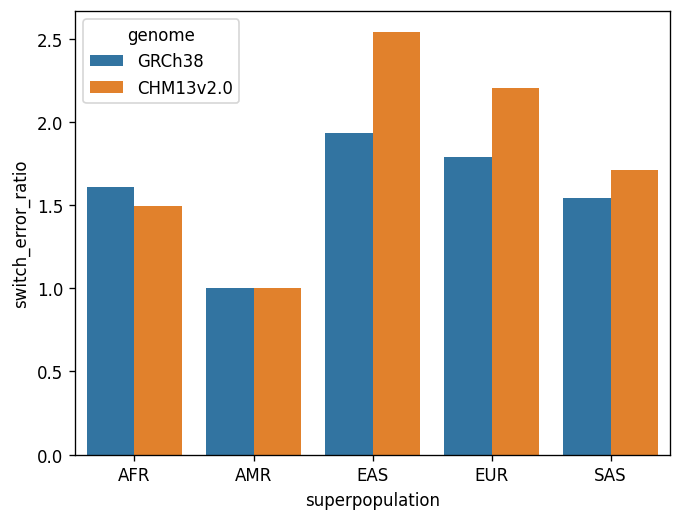

In [ ]:
calc_ancestries = all_ancestries.loc[(all_ancestries.method_of_phasing == 'phased_with_parents_and_pedigree') & 
                                     (all_ancestries.ground_truth_data_source.isin(('HPRC_samples','HGSVC_samples')))]

calc_ancestries = calc_ancestries.groupby(['superpopulation','genome'], observed=True).sum(numeric_only=True)
calc_ancestries['switch_error_rate'] = calc_ancestries.n_switch_errors/calc_ancestries.n_checked*100
calc_ancestries['flip_error_rate'] = calc_ancestries.n_flips/calc_ancestries.n_checked*100
calc_ancestries['true_switch_error_rate'] = calc_ancestries.n_true_switch_errors/calc_ancestries.n_checked*100
calc_ancestries = calc_ancestries.reset_index()
calc_ancestries.loc[calc_ancestries.genome=='GRCh38', 'switch_error_ratio'] = calc_ancestries.loc[calc_ancestries.genome=='GRCh38', 'switch_error_rate'] / calc_ancestries.loc[calc_ancestries.genome=='GRCh38', 'switch_error_rate'].min()
calc_ancestries.loc[calc_ancestries.genome=='CHM13v2.0', 'switch_error_ratio'] = calc_ancestries.loc[calc_ancestries.genome=='CHM13v2.0', 'switch_error_rate'] / calc_ancestries.loc[calc_ancestries.genome=='CHM13v2.0', 'switch_error_rate'].min()
ax = sns.barplot(data=calc_ancestries.reset_index(), x='superpopulation', hue='genome', y='switch_error_ratio')
calc_ancestries.sort_values(['genome','superpopulation'])[['genome','superpopulation', 'switch_error_ratio']]